In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk, re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df = pd.read_csv('src/fake_news_dataset.csv')

df

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake
...,...,...,...,...,...,...,...
19995,House party born.,hit and television I change very our happy doo...,2024-12-04,BBC,Gary Miles,Entertainment,fake
19996,Though nation people maybe price box.,fear most meet rock even sea value design stan...,2024-05-26,Daily News,Maria Mcbride,Entertainment,real
19997,Yet exist with experience unit.,activity loss very provide eye west create wha...,2023-04-17,BBC,Kristen Franklin,Entertainment,real
19998,School wide itself item.,term point general common training watch respo...,2024-06-30,Reuters,David Wise,Health,fake


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [ ]:
df.duplicated().sum(), df.duplicated(subset=['title', 'text']).sum()

(np.int64(0), np.int64(0))

(array([0, 1]), [Text(0, 0, 'fake'), Text(1, 0, 'real')])

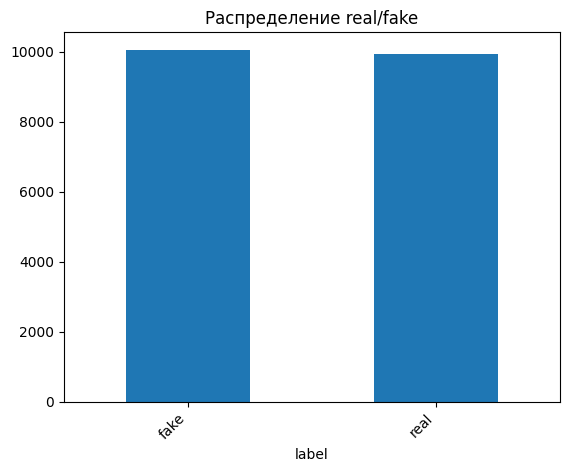

In [ ]:
df['label'].value_counts().plot(kind='bar')
plt.title('Распределение real/fake')
plt.xticks(rotation=45, ha='right')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Health'),
  Text(1, 0, 'Entertainment'),
  Text(2, 0, 'Technology'),
  Text(3, 0, 'Sports'),
  Text(4, 0, 'Business'),
  Text(5, 0, 'Politics'),
  Text(6, 0, 'Science')])

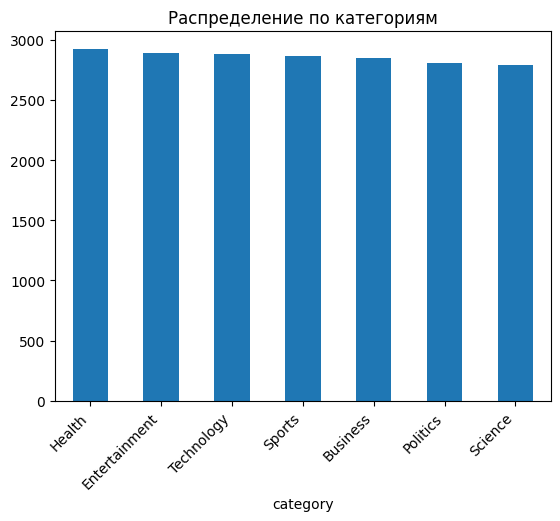

In [ ]:
df['category'].value_counts().plot(kind='bar')
plt.title('Распределение по категориям')
plt.xticks(rotation=45, ha='right')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Entertainment'),
  Text(2, 0, 'Health'),
  Text(3, 0, 'Politics'),
  Text(4, 0, 'Science'),
  Text(5, 0, 'Sports'),
  Text(6, 0, 'Technology')])

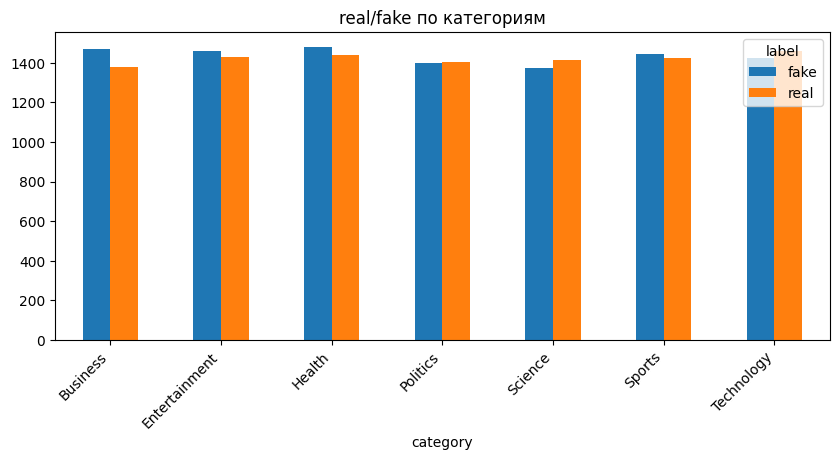

In [ ]:
cat_label_counts = df.groupby(['category', 'label']).size().unstack(fill_value=0)
cat_label_counts.plot(kind='bar', figsize=(10,4))
plt.title('real/fake по категориям')
plt.xticks(rotation=45, ha='right')

In [ ]:
df['source_filled'] = df['source'].fillna('unknown_source')
df['author_filled'] = df['author'].fillna('unknown_author')

In [ ]:
df['source_filled'].value_counts().head(20)

source_filled
Daily News        2439
BBC               2393
The Guardian      2382
CNN               2375
NY Times          2372
Fox News          2362
Reuters           2360
Global Times      2317
unknown_source    1000
Name: count, dtype: int64

In [ ]:
df['author_filled'].value_counts().head(20)

author_filled
unknown_author         1000
Michael Smith            12
John Smith               11
Christopher Johnson       9
David Brown               7
Michael Lee               7
Jennifer Davis            7
Lisa Williams             7
John Brown                7
James Smith               7
Ashley Smith              6
David Johnson             6
David Garcia              6
James Johnson             6
Jeffrey Jones             5
Ryan Smith                5
James Jones               5
Michael Brown             5
Michael Morales           5
Anthony Jones             5
Name: count, dtype: int64

In [ ]:
src_label = df.groupby(['source_filled', 'label']).size().unstack(fill_value=0)
src_label.sort_values('fake', ascending=False).head(10)

label,fake,real
source_filled,,
Daily News,1225,1214
NY Times,1220,1152
CNN,1202,1173
Fox News,1198,1164
The Guardian,1188,1194
BBC,1178,1215
Reuters,1176,1184
Global Times,1166,1151
unknown_source,503,497


In [ ]:
auth_label = df.groupby(['author_filled', 'label']).size().unstack(fill_value=0)
auth_label.sort_values('fake', ascending=False).head(10)

label,fake,real
author_filled,,
unknown_author,485,515
James Smith,6,1
Christopher Johnson,5,4
John Brown,5,2
Michael Williams,4,1
Michael Smith,4,8
David Jones,4,1
David Garcia,4,2
Matthew Smith,4,1


In [ ]:
df['title_len_words'] = df['title'].str.split().str.len()
df['text_len_words']  = df['text'].str.split().str.len()

In [ ]:
len_label = df.groupby(['text_len_words', 'label']).size().unstack(fill_value=0)
len_label.sort_values('text_len_words', ascending=False).head(10)

label,fake,real
text_len_words,,
300,109,108
299,105,96
298,98,100
297,79,93
296,105,94
295,102,85
294,118,121
293,106,95
292,86,85


Text(0.5, 1.0, 'Длина заголовка (слова)')

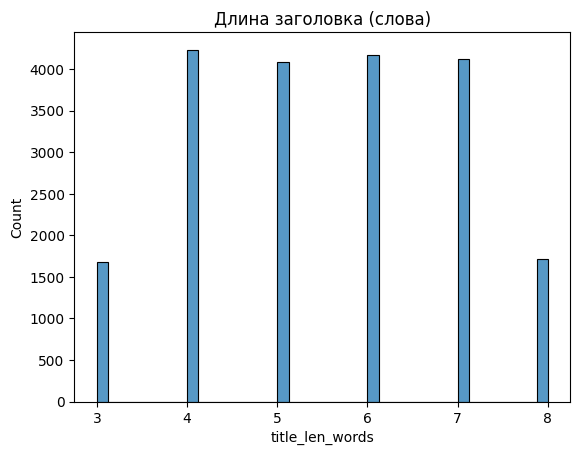

In [ ]:
sns.histplot(df['title_len_words'], bins=40)
plt.title('Длина заголовка (слова)')

Text(0.5, 1.0, 'Длина текста (слова)')

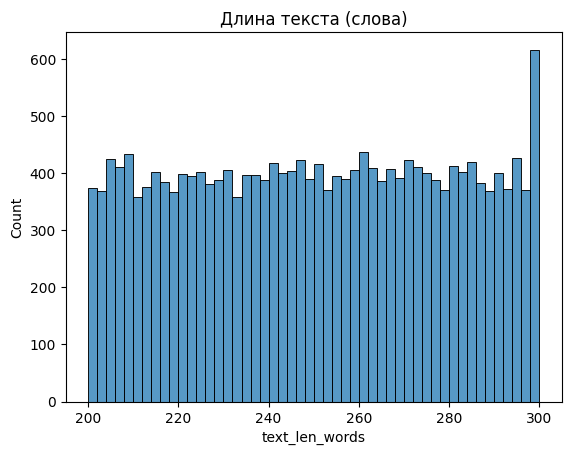

In [ ]:
sns.histplot(df['text_len_words'], bins=50)
plt.title('Длина текста (слова)')

Text(0.5, 1.0, 'Длина текста по меткам')

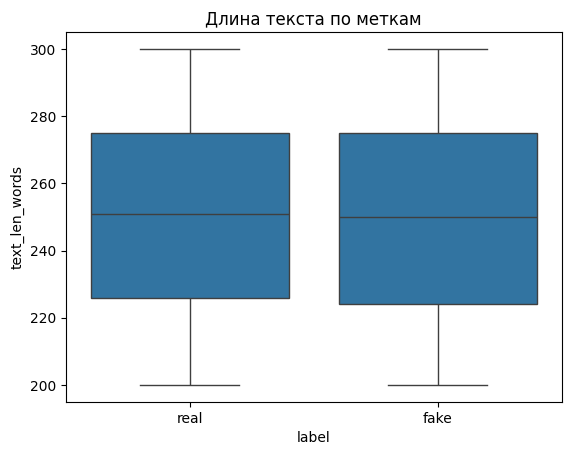

In [ ]:
sns.boxplot(x='label', y='text_len_words', data=df)
plt.title('Длина текста по меткам')

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['mr', 'else'])
lemmatizer = WordNetLemmatizer()

def preprocess(text, reg=r'[^a-zA-Z\s]'):
    text = re.sub(reg, '', text.lower())
    tokens = nltk.word_tokenize(text)
    return [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

In [ ]:
df['tokens'] = df['text'].apply(preprocess)

In [ ]:
all_tokens = [t for toks in df['tokens'] for t in toks]
Counter(all_tokens).most_common(30)

[('listen', 5341),
 ('purpose', 5339),
 ('wear', 5338),
 ('summer', 5323),
 ('thought', 5320),
 ('child', 5314),
 ('direction', 5312),
 ('factor', 5311),
 ('ability', 5311),
 ('get', 5310),
 ('wide', 5308),
 ('relate', 5306),
 ('size', 5305),
 ('member', 5305),
 ('produce', 5304),
 ('lose', 5304),
 ('bar', 5295),
 ('leave', 5295),
 ('look', 5290),
 ('act', 5287),
 ('near', 5287),
 ('reflect', 5285),
 ('appear', 5284),
 ('congress', 5284),
 ('magazine', 5284),
 ('food', 5283),
 ('success', 5282),
 ('agree', 5282),
 ('upon', 5282),
 ('economy', 5282)]

In [ ]:
fake_tokens = [t for toks in df.loc[df['label']=='fake','tokens'] for t in toks]
real_tokens = [t for toks in df.loc[df['label']=='real','tokens'] for t in toks]

print(f'FAKE:\n{Counter(fake_tokens).most_common(20)}')
print(f'REAL:\n{Counter(real_tokens).most_common(20)}')

FAKE:
[('summer', 2753), ('wide', 2742), ('moment', 2722), ('direction', 2719), ('wear', 2718), ('lose', 2718), ('rich', 2718), ('easy', 2717), ('offer', 2715), ('take', 2711), ('fear', 2710), ('listen', 2707), ('relate', 2703), ('significant', 2702), ('story', 2699), ('claim', 2699), ('subject', 2699), ('start', 2699), ('adult', 2697), ('form', 2697)]
REAL:
[('economy', 2742), ('member', 2727), ('reflect', 2718), ('purpose', 2708), ('bar', 2705), ('size', 2703), ('thought', 2703), ('build', 2700), ('painting', 2697), ('drive', 2696), ('remain', 2691), ('produce', 2686), ('congress', 2682), ('threat', 2682), ('play', 2680), ('minute', 2679), ('near', 2678), ('heavy', 2674), ('dark', 2673), ('act', 2668)]


In [ ]:
# TF-IDF - векторизация (основана на частоте, фактически вероятность встретить какое-то слово)
# Находим 20 топ-слов для фейковых новостей и правдивых новостей
texts = df['text'].astype(str).tolist()
labels = df['label'].tolist()

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5
)
X_tfidf = tfidf.fit_transform(texts)
feature_names = np.array(tfidf.get_feature_names_out())

def top_tfidf_words(label_value, top_n=20):
    idx = np.where(np.array(labels) == label_value)[0]
    class_tfidf = X_tfidf[idx].mean(axis=0).A1
    top_idx = np.argsort(class_tfidf)[::-1][:top_n]
    return pd.DataFrame({
        'term': feature_names[top_idx],
        'mean_tfidf': class_tfidf[top_idx]
    })

top_fake = top_tfidf_words('fake')
top_real = top_tfidf_words('real')

print(f'FAKE:\n{top_fake.head(20)}')
print(f'REAL:\n{top_real.head(20)}')

FAKE:
           term  mean_tfidf
0        summer    0.012944
1          wide    0.012935
2        moment    0.012899
3          take    0.012853
4   significant    0.012851
5          rich    0.012837
6         claim    0.012829
7         offer    0.012815
8          easy    0.012814
9          fear    0.012805
10           it    0.012797
11      subject    0.012779
12    direction    0.012779
13          him    0.012775
14         lose    0.012768
15        adult    0.012763
16        start    0.012749
17         pick    0.012748
18         form    0.012747
19       during    0.012739
REAL:
        term  mean_tfidf
0    economy    0.013065
1    reflect    0.012955
2       them    0.012952
3     member    0.012920
4   painting    0.012863
5       else    0.012856
6     remain    0.012855
7      drive    0.012847
8      build    0.012831
9       play    0.012830
10       bar    0.012828
11      size    0.012817
12    threat    0.012791
13   thought    0.012790
14   purpose    0.012778


**Что делает LDA:**

Вероятностная модель, которая предполагает: каждый документ — смесь нескольких тем, а каждая тема — распределение по словам.

Находит скрытые темы в корпусе текстов.

**Что делает NMF:**

Метод матричной факторизации: раскладывает матрицу TF‑IDF на две неотрицательные матрицы:

W — «темы × слова» (какие слова характеризуют тему);

H — «документы × темы» (какие темы есть в документе).

В отличие от LDA, не вероятностный, а алгебраический метод.

In [ ]:
n_topics = 10

lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='batch',
    random_state=42
)
lda_topics = lda.fit_transform(X_tfidf)

nmf = NMF(n_components=n_topics, random_state=42)
nmf_topics = nmf.fit_transform(X_tfidf)

def print_topics(model, n_top_words=15, title=""):
    comps = model.components_
    for topic_idx, topic in enumerate(comps):
        top_idx = topic.argsort()[::-1][:n_top_words]
        terms = " ".join(feature_names[top_idx])
        print(f"{title} topic {topic_idx}: {terms}")

print_topics(lda, title='LDA')
print_topics(nmf, title='NMF')

LDA topic 0: good in on miss top society rate despite these almost material sense blue ago necessary help stuff now against offer score challenge have series forward morning still gun usually bad
LDA topic 1: start according most later question wear tree as money perhaps edge have seem million toward because us car result apply pick full conference civil reason wonder this style know movement
LDA topic 2: else listen wear summer wide get direction purpose factor edge act look pattern reflect produce
LDA topic 3: international reach human animal moment director cut return husband worry human take person remember collection trouble case door take bar level director day ago himself lay purpose carry most life
LDA topic 4: republican team glass believe most later know movement conference above start campaign network study usually bad sense only air agency herself answer ground business throughout candidate west who product light
LDA topic 5: pay fight upon mouth cup not still skill they si

c:\ashes\other\courses_ml\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# Анализируем, как распределены тематические компоненты (получили через LDA и NMF) по классам
labels_arr = np.array(df['label'])

def topic_distribution_by_label(topic_matrix, name):
    df_topics = pd.DataFrame(topic_matrix)
    df_topics['label'] = labels_arr
    mean_by_label = df_topics.groupby('label').mean()
    print(f'\n{name} mean topic proportions by label:\n', mean_by_label)
    return mean_by_label

lda_by_label = topic_distribution_by_label(lda_topics, 'LDA')
nmf_by_label = topic_distribution_by_label(nmf_topics, 'NMF')


LDA mean topic proportions by label:
               0         1         2         3         4         5         6  \
label                                                                         
fake   0.022179  0.006831  0.917122  0.006851  0.006844  0.006998  0.006838   
real   0.022121  0.006827  0.917244  0.006845  0.006839  0.006997  0.006833   

              7         8         9  
label                                
fake   0.006983  0.007197  0.012158  
real   0.006972  0.007252  0.012070  

NMF mean topic proportions by label:
               0         1         2         3         4         5         6  \
label                                                                         
fake   0.013650  0.015704  0.016894  0.017032  0.016961  0.017695  0.017105   
real   0.013534  0.015976  0.017071  0.017008  0.016999  0.017666  0.016918   

              7         8         9  
label                                
fake   0.018283  0.015826  0.016044  
real   0.018199  0.015

Вывод: fake и real почти не различаются на уровне тем: распределения очень близки

В LDA доминирует одна тема: у fake и у real тема 2 имеет среднее значение ≈ 0.917, остальные темы около 0.007–0.02

In [ ]:
# невзвешенный подсчёт
cv = CountVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5
)

X_counts = cv.fit_transform(texts)
cv_features = np.array(cv.get_feature_names_out())

lda_all = LatentDirichletAllocation(
    n_components=10,
    learning_method='batch',
    random_state=42
)
lda_all_topics = lda_all.fit_transform(X_counts)

In [ ]:
fake_texts = df.loc[df['label']=='fake', 'text'].astype(str).tolist()
real_texts = df.loc[df['label']=='real', 'text'].astype(str).tolist()

cv_fake = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5)
X_fake = cv_fake.fit_transform(fake_texts)
feat_fake = np.array(cv_fake.get_feature_names_out())

cv_real = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5)
X_real = cv_real.fit_transform(real_texts)
feat_real = np.array(cv_real.get_feature_names_out())

n_topics = 5

lda_fake = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='batch',
    random_state=42
).fit(X_fake)

lda_real = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='batch',
    random_state=42
).fit(X_real)

In [ ]:
def print_topics_(model, feature_names, title, n_top_words=15):
    print(f'\n{title}')
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[::-1][:n_top_words]
        terms = " ".join(feature_names[top_idx])
        print(f"topic {topic_idx}: {terms}")

print_topics_(lda_fake, feat_fake, 'FAKE topics')
print_topics_(lda_real, feat_real, 'REAL topics')


FAKE topics
topic 0: director relationship manager age instead rich over reach establish book throw ever industry figure much
topic 1: international let offer care respond suddenly raise story trial no amount surface full fast describe
topic 2: recognize wait read real so table turn early safe policy country song remain place whose
topic 3: make impact simple direction party approach anyone be foot glass watch common agent certainly follow
topic 4: who determine magazine measure notice crime stop actually money include property culture hope sit well

REAL topics
topic 0: very office travel hundred laugh point within little history need tv true stay environmental money
topic 1: size few can though teach establish from new stuff stock kid save learn no already
topic 2: sound shoulder never right trouble upon collection almost power grow here star return reveal mention
topic 3: management me floor two official act both art prove three him idea heavy play maintain
topic 4: thing billion e

In [ ]:
def topic_distribution_by_label(topic_matrix, name='LDA'):
    n_topics = topic_matrix.shape[1]
    col_names = [f'topic_{i}' for i in range(n_topics)]
    df_topics = pd.DataFrame(topic_matrix, columns=col_names)

    df_topics['label'] = labels

    mean_by_label = df_topics.groupby('label')[col_names].mean()

    print(f'\n{name} mean topic proportions by label:\n{mean_by_label}\n')
    return mean_by_label

lda_by_label = topic_distribution_by_label(lda_all_topics, name='LDA (BoW)')


LDA (BoW) mean topic proportions by label:
        topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
label                                                                         
fake   0.138969  0.012118  0.156342  0.098933  0.073692  0.110366  0.078567   
real   0.139017  0.011270  0.152986  0.099176  0.073889  0.108316  0.077561   

        topic_7   topic_8  topic_9  
label                               
fake   0.100827  0.109357  0.12083  
real   0.100964  0.111480  0.12534  



Вывод: темы в LDA на BoW распределяются по fake и real почти одинаково: различия по каждому топику находятся на уровне тысячных.

In [ ]:
sentences = df['tokens'].tolist()
w2v = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

def sent_vec(tokens, model, dim=100):
    vs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vs, axis=0) if vs else np.zeros(dim)

X_w2v = np.vstack([sent_vec(toks, w2v, 100) for toks in sentences])

Text(0, 0.5, 'PC2')

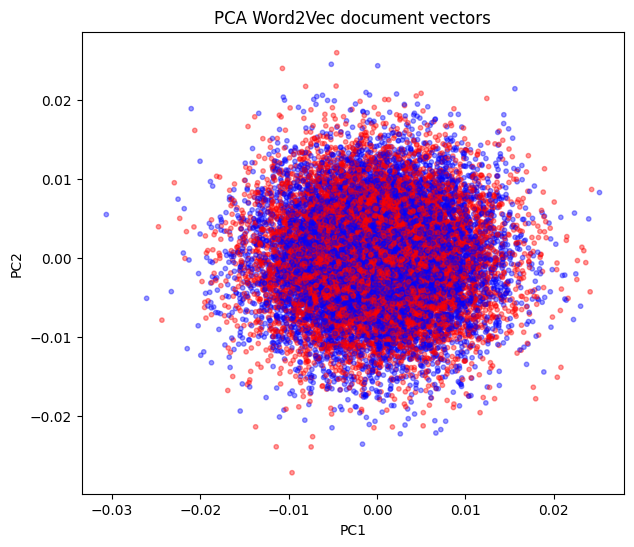

In [ ]:
# визуализация в двумерном пространстве
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_w2v)

label_map = {'fake': 0, 'real': 1}
colors = ['red' if l == 'fake' else 'blue' for l in df['label']]

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, alpha=0.4, s=10)
plt.title('PCA Word2Vec document vectors')
plt.xlabel('PC1'); plt.ylabel('PC2')

Text(0, 0.5, 'dim2')

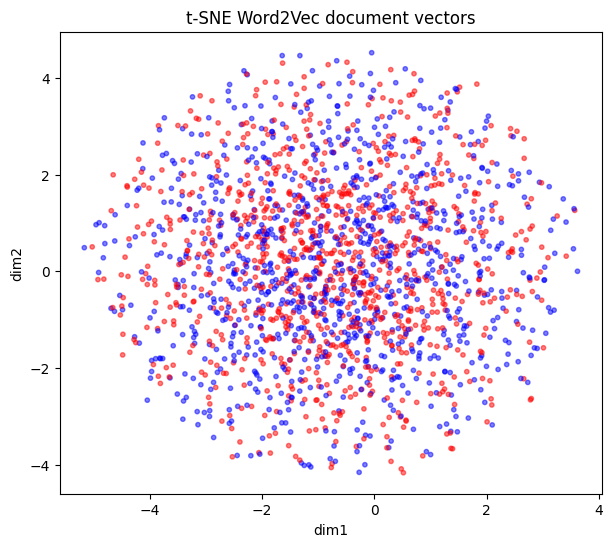

In [ ]:
sample_n = 2000
idx = np.random.choice(len(X_w2v), size=sample_n, replace=False)
X_sample = X_w2v[idx]
labels_sample = df['label'].iloc[idx].tolist()
colors_s = ['red' if l == 'fake' else 'blue' for l in labels_sample]

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    max_iter=2000,
    random_state=42,
    init='pca'
)
X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=colors_s, alpha=0.5, s=10)
plt.title('t-SNE Word2Vec document vectors')
plt.xlabel('dim1'); plt.ylabel('dim2')

Крайне подозрительный датасет, по какому принципу ни дели, всё одинаково для фейковых и для настоящих.И распределение по топикам ровненькое и всё как-то очень ровненько.